In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import torch.nn.functional as F
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
direct = '/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/nd-twins-0006/faces/train/'

In [4]:
#read metadata and construct scv for DataLoader
df = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins-recognition/dataloader/image-metadata-3.0.csv')
df_relation = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins-recognition/twins-relationship-info.csv')

In [5]:
class TwinsDataloader(Dataset):
    def __init__(self, dataroot, df_img, df_relations, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe matadata(hasn't been changed)
        df_relatinos: pandas dataframe with relations between classes
        transform: torchvision flip and notflip transforms for  images(dict)
        '''
        self.dataroot = dataroot
        self.df = df[df[' yaw']==0]
        self.transform = transform
        self.relations=df_relations
        self.list_notexist=[]
    def __getitem__(self, index):
        
        def get_img_path(img_id):
            return self.dataroot+f'{img_id[:5]}/{img_id[:-4]}__face.jpg'
        
        monetochka=np.random.randint(0,2)
        #print(monetochka)
        id_a = self.df['filename'].iloc[index]
        img_a = Image.open(get_img_path(id_a))
        
        if monetochka==0: 
            find_id=self.relations['subject_id1'].str.find(id_a[:5])
            #print(find_id[find_id!=-1].index.tolist())
            if find_id[find_id!=-1].index.tolist():               
                id_b=self.relations['subject_id2'].iloc[find_id[find_id!=-1].index].values
                relation=self.relations['relationship_type'].iloc[find_id[find_id!=-1].index].values


                if relation[0] in ['Fraternal','Identical','IdenticalMirror','IdenticalTriplet']:
                    flag='Twins'
                    find_id=self.df['filename'].str.find(str(id_b[0][4:]))
                    id_b=self.df['filename'].loc[find_id[find_id!=-1].index[np.random.randint(0,len(find_id[find_id!=-1].index))]]
                    img_b = Image.open(get_img_path(id_b))
                    img_b=self.transform['notflip'](img_b)
                else:
                    id_b=id_a
                    img_b=img_a.copy()
                    img_b=self.transform['flip'](img_b)
                    flag='Not Twins'
            else:
                id_b=id_a
                img_b=img_a.copy()
                img_b=self.transform['flip'](img_b)
                flag='Not Twins'
        else:
            id_b=id_a
            img_b=img_a.copy()
            img_b=self.transform['flip'](img_b)
            flag='Not Twins'
    
        img_a = self.transform['notflip'](img_a)

        id_a=id_a[:5]
        id_b=id_b[:5]
        return {'img_a': img_a, 'img_b': img_b, 'class_a':id_a,'class_b':id_b,'label':flag}

    def __len__(self):
        return self.df.shape[0]

In [6]:
data_transforms = {
    'flip': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'notflip': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [7]:
twins_dataset = TwinsDataloader(direct, df,df_relation ,data_transforms)
dataset = DataLoader(twins_dataset, batch_size=10,shuffle=True)

## Check work of dataloader

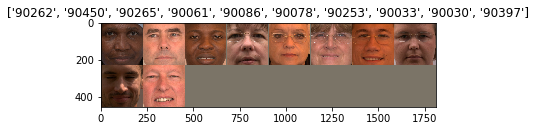

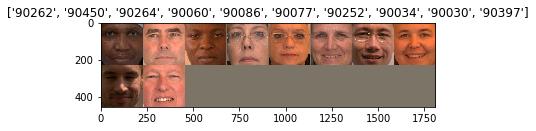

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
T = next(iter(dataset))

# Make a grid from batch
out = torchvision.utils.make_grid(T['img_a'])
imshow(out, title=[x for x in T['class_a']])

out = torchvision.utils.make_grid(T['img_b'])
imshow(out, title=[x for x in T['class_b']])

In [9]:
T['img_a'].shape

torch.Size([10, 3, 224, 224])

### CONCAT OF CONV FEATURES AND LANDMARKS

In [10]:
# concatenate conv MobileFaceNet and classifier
class FinModel(nn.Module):
    def __init__(self,flatten_model,classifier_model):
        super(FinModel, self).__init__()
        self.to_flat_model=flatten_model
        self.classifier_model=classifier_model
    def forward(self,x):
        outputs=self.to_flat_model(x)
        outputs=self.classifier_model(outputs)
        return outputs

## Load and define the model

In [11]:
from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"./model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)

In [13]:
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

    
#define model and fix hidden features size
model_conv = ModelBottom(model)
outputs = model_conv(T['img_a'])
hid_size=outputs.data.shape[1]
label_dict={'Twins':1,'Not Twins':0}
# classes=os.listdir(direct)
# n_classes=len(classes)
#define classifier

fc_layers = nn.Sequential(
                      nn.Linear(hid_size, 500),
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True), 
                      nn.Linear(500,5),
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True))
for param in model_conv.parameters():
    param.requires_grad = False

### Model where you can finetune pretrained one

In [14]:
 class myModel(nn.Module):
        def __init__(self):
            super(myModel,self).__init__()
            self.model_start = model_conv
            self.fc_layers = nn.Sequential(
                      nn.Linear(hid_size, 500),
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True), 
                      nn.Linear(500,5),
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True))
   	    
        def forward(self,x):
            out1 = self.model_start(x)
            return self.fc_layers(out1)

In [15]:
model_final = myModel()

In [16]:
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

le=LabelEncoder()
lb=LabelBinarizer()
classes=os.listdir(direct)
le.fit(classes)
lb.fit(classes)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

### Block for losses


In [17]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [54]:
def train(output_path, model, dataloader, optimizer,criterion, device, n_epochs=100):
    model.cuda(device)
    loss_hist=[]
    for epoch in range(n_epochs):
        loss_epoch = 0
        for i,batch_item in enumerate(dataloader):
            result_img_a=model(batch_item['img_a'].cuda(device))
            result_img_b=model(batch_item['img_b'].cuda(device))
            label=batch_item['label']
            label=[label_dict[x] for x in label]
            loss_batch=0
            loss=0
            optimizer.zero_grad()
            
            for j in range(result_img_a.shape[0]):
                loss += criterion(result_img_a[j][None],result_img_b[j][None],label[j])        
            loss_batch+=loss.item()
            if i % 100 == 0: print("Loss_batch={}".format(loss_batch))
            loss.backward(retain_graph=True)
            optimizer.step()
            loss_epoch+=loss_batch
           
           
        loss_hist.append(loss_epoch)
        torch.save(model.state_dict(), os.path.join(os.getcwd(),str(output_path)) + '/{}_epoch.pt'.format(epoch+1))
        plt.plot(loss_hist) 
        plt.title('loss')
        plt.legend()
        plt.show()    
        
            

Loss_batch=23.99994468688965
Loss_batch=27.999935150146484
Loss_batch=7.999981880187988
Loss_batch=31.99992561340332
Loss_batch=11.99997329711914
Loss_batch=27.999935150146484
Loss_batch=23.99994468688965
Loss_batch=23.99994468688965


No handles with labels found to put in legend.


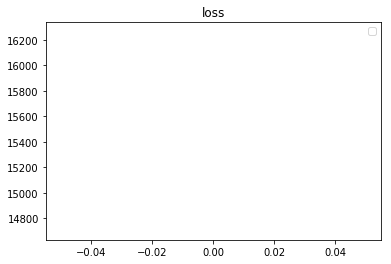

Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=23.99994468688965
Loss_batch=15.999963760375977
Loss_batch=27.999935150146484
Loss_batch=23.99994468688965
Loss_batch=15.999963760375977
Loss_batch=15.999963760375977


No handles with labels found to put in legend.


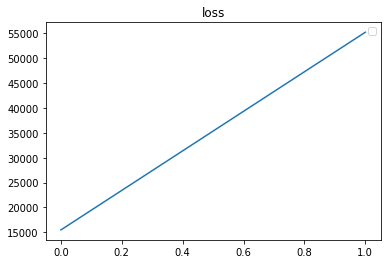

Loss_batch=19.999954223632812
Loss_batch=27.999935150146484
Loss_batch=7.999981880187988
Loss_batch=31.99992561340332
Loss_batch=23.99994468688965
Loss_batch=11.99997329711914
Loss_batch=19.999954223632812
Loss_batch=23.99994468688965


No handles with labels found to put in legend.


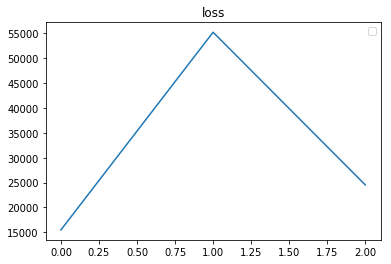

Loss_batch=15.999963760375977
Loss_batch=23.99994468688965
Loss_batch=15.999963760375977
Loss_batch=11.99997329711914
Loss_batch=15.999963760375977
Loss_batch=11.99997329711914
Loss_batch=3.999990940093994
Loss_batch=27.999935150146484


No handles with labels found to put in legend.


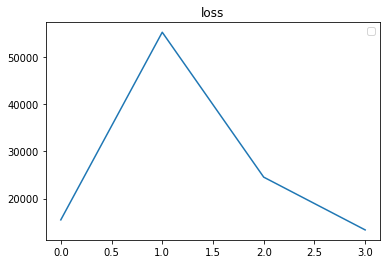

Loss_batch=19.999954223632812
Loss_batch=11.99997329711914
Loss_batch=11.99997329711914
Loss_batch=11.99997329711914
Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=19.999954223632812
Loss_batch=7.999981880187988


No handles with labels found to put in legend.


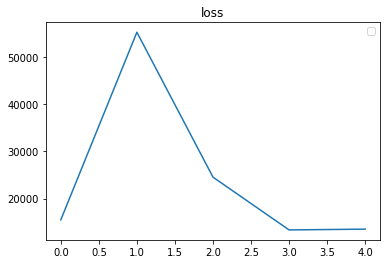

Loss_batch=15.999963760375977
Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=27.999935150146484
Loss_batch=27.999935150146484
Loss_batch=15.999963760375977
Loss_batch=19.999954223632812
Loss_batch=15.999963760375977


No handles with labels found to put in legend.


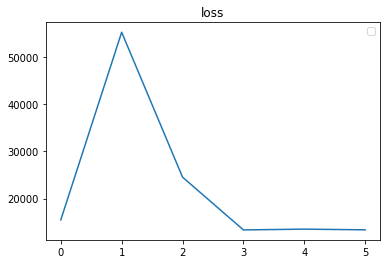

Loss_batch=15.999963760375977
Loss_batch=15.999963760375977
Loss_batch=11.99997329711914
Loss_batch=11.99997329711914
Loss_batch=23.99994468688965
Loss_batch=23.99994468688965
Loss_batch=23.99994468688965
Loss_batch=11.99997329711914


No handles with labels found to put in legend.


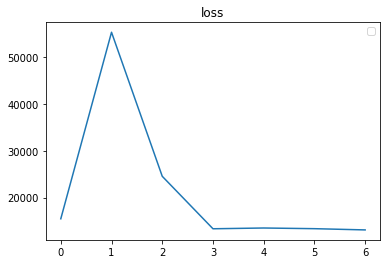

Loss_batch=19.999954223632812
Loss_batch=15.999963760375977
Loss_batch=7.999981880187988
Loss_batch=15.999963760375977
Loss_batch=15.999963760375977
Loss_batch=11.99997329711914
Loss_batch=15.999963760375977
Loss_batch=15.999963760375977


No handles with labels found to put in legend.


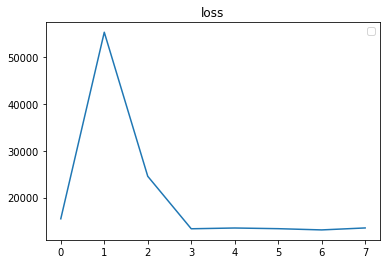

Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=7.999981880187988
Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=15.999963760375977
Loss_batch=15.999963760375977
Loss_batch=23.99994468688965


No handles with labels found to put in legend.


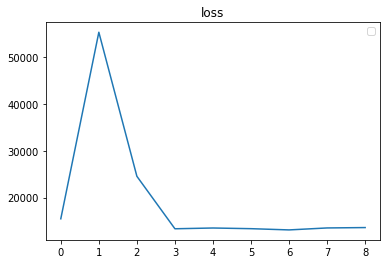

Loss_batch=19.999954223632812
Loss_batch=11.99997329711914
Loss_batch=15.999963760375977
Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=19.999954223632812


No handles with labels found to put in legend.


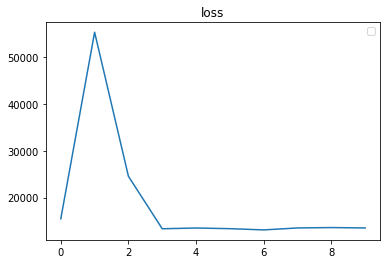

Loss_batch=23.99994468688965
Loss_batch=11.99997329711914
Loss_batch=11.99997329711914
Loss_batch=19.999954223632812
Loss_batch=15.999963760375977
Loss_batch=19.999954223632812
Loss_batch=23.99994468688965
Loss_batch=15.999963760375977


No handles with labels found to put in legend.


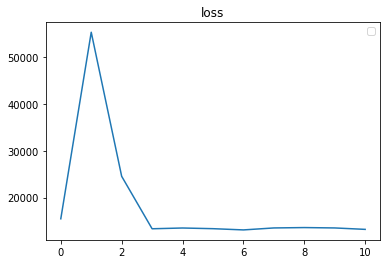

Loss_batch=19.999954223632812
Loss_batch=19.999954223632812


KeyboardInterrupt: 

In [55]:
twins_dataset = TwinsDataloader(direct, df,df_relation ,data_transforms)
dataset = DataLoader(twins_dataset, batch_size=10,shuffle=True)
optimizer = optim.Adam(model_final.parameters(),lr = 0.0005)
criterion=ContrastiveLoss()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

train("mobile_chkpts",model_final,dataset,optimizer,criterion,device,n_epochs=40)